# Image Denoising - MINST digits
Here is a simple experiment in using a convolutional autoencoder to denoise images. In this case, we'll be cleaning Gausian noise off the images from the MINST digits dataset.

In [1]:
# Imports
import sys
sys.path.append('../')
from BuildingBlocks import Conv2Dblock, Deconv2Dblock
from ImageAutoEncoder import ImageAutoEncoder
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Load, concatenate and normalize the training data
(xtrain, ytrain), (xtest, ytest) = tf.keras.datasets.mnist.load_data()
data = np.concatenate([xtest,xtrain])/255

### The Model
We're going to build an autoencoder with fewer convolutional layers than the previous example (the image dataset of black and white digits should have relatively few features to capture), and a fairly wide bottleneck, so that the model has no trouble re-creating the MINST digits without any added noise.

In [3]:
c0 = Conv2Dblock(8, (2,2), pool_size=(2,2))
c1 = Conv2Dblock(16, (2,2), pool_size=(2,2))
d0 = Deconv2Dblock(16, (3,3), (2,2))
d1 = Deconv2Dblock(8, (4,4), (2,2))
auto = ImageAutoEncoder((28,28,1), 288, [c0,c1], decode_blocks=[d0,d1], latent_activation='sigmoid')

We'll train up a version of this archetecture to make sure that the model can accurately recreate the original images in the absence of noise:

Epoch 1/20
70/70 [==============================] - 32s 448ms/step - loss: 0.6683 - accuracy: 0.5502
Epoch 2/20
70/70 [==============================] - 31s 447ms/step - loss: 0.4515 - accuracy: 0.7318
Epoch 3/20
70/70 [==============================] - 33s 465ms/step - loss: 0.2815 - accuracy: 0.8027
Epoch 4/20
70/70 [==============================] - 33s 473ms/step - loss: 0.1958 - accuracy: 0.8124
Epoch 5/20
70/70 [==============================] - 34s 480ms/step - loss: 0.1559 - accuracy: 0.8137
Epoch 6/20
70/70 [==============================] - 33s 477ms/step - loss: 0.1333 - accuracy: 0.8139
Epoch 7/20
70/70 [==============================] - 34s 482ms/step - loss: 0.1192 - accuracy: 0.8142
Epoch 8/20
70/70 [==============================] - 39s 556ms/step - loss: 0.1100 - accuracy: 0.8143
Epoch 9/20
70/70 [==============================] - 35s 494ms/step - loss: 0.1030 - accuracy: 0.8150
Epoch 10/20
70/70 [==============================] - 33s 478ms/step - loss: 0.0979 - accura

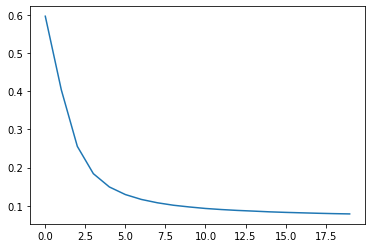

In [4]:
auto.train(data, batch=1000, epochs=20); plt.plot(auto.loss)

Text(0, 0.5, 'Encoded/Decoded')

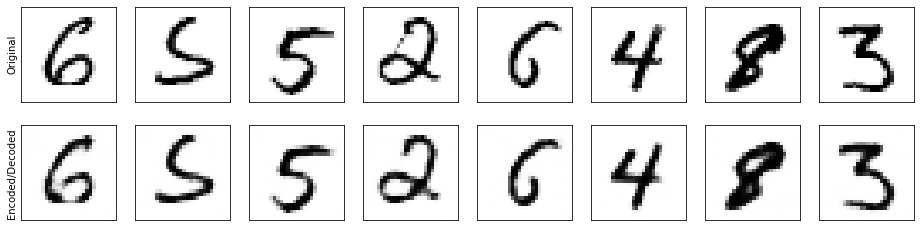

In [5]:
transformed = auto.autoencoder.predict(data)
fig, axs = plt.subplots(2, 8, figsize=(16,4), sharex=True, sharey=True)
for i in range(8):
    im = np.random.randint(0, data.shape[0])
    axs[0][i].imshow(data[im,:], cmap='Greys', interpolation='none')
    axs[1][i].imshow(transformed[im,:], cmap='Greys', interpolation='none')
    axs[0][i].set_xticks([]); axs[0][i].set_yticks([])
    axs[1][i].set_xticks([]); axs[1][i].set_yticks([])
axs[0][0].set_ylabel("Original"); axs[1][0].set_ylabel("Encoded/Decoded")

Looking pretty good so far.

### Adding Noise
We'll be adding random Gaussian white noise to the images. (We might also try uniform noise, but this is likely closer to actual scientific data cleanup.)

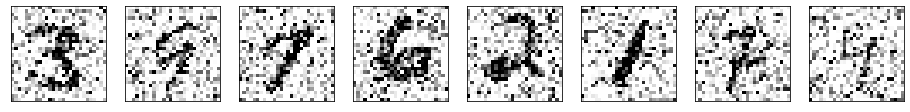

In [6]:
# Visualizing the data with added noise.
noisydata = data + np.random.normal(size=data.shape, scale=0.5)
noisydata = np.clip(noisydata, 0, 1)
fig, axs = plt.subplots(1, 8, figsize=(16,2), sharex=True, sharey=True)
for i in range(8):
    im = np.random.randint(0, data.shape[0])
    axs[i].imshow(noisydata[im,:], cmap='Greys', interpolation='none')
    axs[i].set_xticks([]); axs[0].set_yticks([])

We'll now reset and retrain the model using noisy data as input. We're going to make a custom training loop to do this to do this because:
- We'll be passing the noisy data into the auto-encoder, but having the loss function compare output to the clean data.
- We're going to want new and different random noise to be added to each image every time the model trains on it, which means that we want to re-noise the data every epoch.

In [7]:
def train_on_noise(auto, data, batch, epochs):
    for e in range(epochs):
        noisydata = data + np.random.normal(size=data.shape, scale=0.5)
        noisydata = np.clip(noisydata, 0, 1)
        auto.autoencoder.fit(noisydata, data, batch_size=batch, epochs=1,
                       verbose=auto.verbose, shuffle=True)
        auto.loss += (auto.autoencoder.history.history['loss'])
        auto.accuracy += (auto.autoencoder.history.history['accuracy'])

70/70 [==============================] - 40s 576ms/step - loss: 0.1062 - accuracy: 0.8126


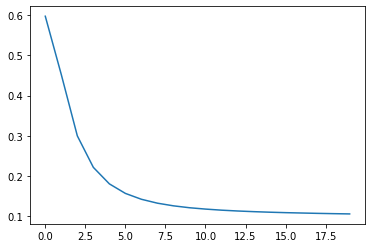

In [8]:
# Regenerate/reset the autoencoder and train on noisy data
del auto
auto = ImageAutoEncoder((28,28,1), 288, [c0,c1], decode_blocks=[d0,d1], latent_activation='sigmoid')
train_on_noise(auto, data, 1000, 20); plt.plot(auto.loss)

### Visualising the results

#### Fig 1: Recreating of original images with noise.
Here we'll take a random sample of the images, see what they look like with gaussian noise, and then see what the autoencoder produces as a cleaned image.

Text(0, 0.5, 'Cleaned')

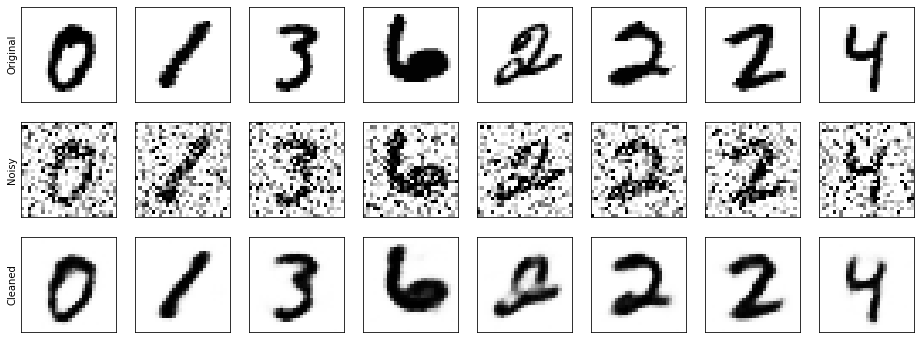

In [9]:
# Visualizing the efficacy on different images:
noisydata = data + np.random.normal(size=data.shape, scale=0.5)
noisydata = np.clip(noisydata, 0, 1)
transformed = auto.autoencoder.predict(noisydata)
fig, axs = plt.subplots(3, 8, figsize=(16,6), sharex=True, sharey=True)
for i in range(8):
    im = np.random.randint(0, data.shape[0])
    axs[0][i].imshow(data[im], cmap='Greys', interpolation='none')
    axs[1][i].imshow(noisydata[im], cmap='Greys', interpolation='none')
    axs[2][i].imshow(transformed[im], cmap='Greys', interpolation='none')
    axs[0][i].set_xticks([]); axs[0][i].set_yticks([])
    axs[1][i].set_xticks([]); axs[1][i].set_yticks([])
    axs[2][i].set_xticks([]); axs[2][i].set_yticks([])
axs[0][0].set_ylabel("Original")
axs[1][0].set_ylabel("Noisy")
axs[2][0].set_ylabel("Cleaned")

#### Fig 2: Different iterations of the noise.
Next, let's look at exactly the same image, but with different noise in each sample, and see how the autoencoder does at cleaning it.

Text(0.5, 0, 'Original Image')

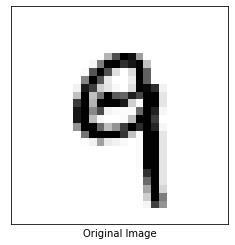

In [10]:
# Pulling the random image:
i = np.random.randint(0, data.shape[0])
img = np.tile(data[i], (8,1,1))
plt.imshow(img[0], cmap="Greys", interpolation='none')
plt.xticks([]);plt.yticks([]); plt.xlabel("Original Image")

Text(0, 0.5, 'Cleaned')

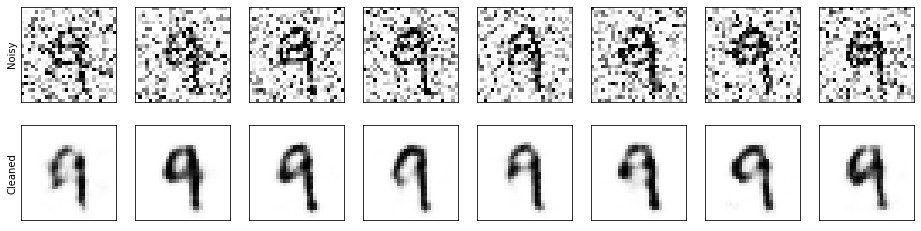

In [11]:
# Visualizing the efficacy under different iterations of the noise
noisyimg = img + np.random.normal(size=img.shape, scale=0.5)
noisyimg = np.clip(noisyimg, 0, 1)
reimg = auto.autoencoder.predict(noisyimg)
fig, axs = plt.subplots(2, 8, figsize=(16,4), sharex=True, sharey=True)
for i in range(8):
    noisyim = data + np.random.normal(size=data[im].shape, scale=0.5)
    noisyim = np.clip(noisyim, 0, 1)
    axs[0][i].imshow(noisyimg[i], cmap='Greys', interpolation='none')
    axs[1][i].imshow(reimg[i], cmap='Greys', interpolation='none')
    axs[0][i].set_xticks([]); axs[0][i].set_yticks([])
    axs[1][i].set_xticks([]); axs[1][i].set_yticks([])
axs[0][0].set_ylabel("Noisy")
axs[1][0].set_ylabel("Cleaned")

If I repeat this experiment a few times, I can see that there appear to be a few edge-case incidents where unfortunate fluctuations in the noise fool the model into erasing solid lines or creating new ones. This often seems to result in finer detail being lost in the noise.

#### Fig 3: Interpreting noise itself.
A final interesting thing to look at would be: how does the autoencoder behave when the imabes presented are *only* noise, without any underlying structure?

Text(0, 0.5, 'Interpretation')

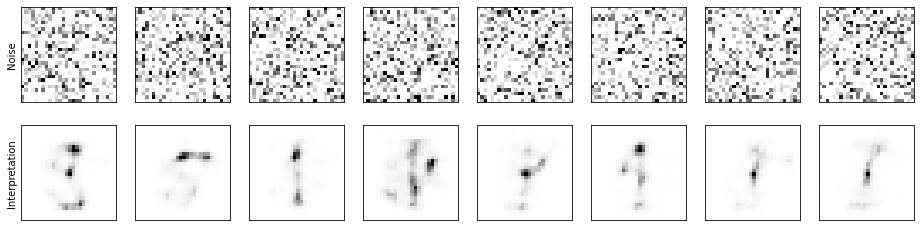

In [12]:
noise = np.random.normal(size=(8,28,28), scale=0.5)
noise = np.clip(noise, 0, 1)
interp = auto.autoencoder.predict(noise)
fig, axs = plt.subplots(2, 8, figsize=(16,4), sharex=True, sharey=True)
for i in range(8):
    noisyim = data + np.random.normal(size=data[im].shape, scale=0.5)
    noisyim = np.clip(noisyim, 0, 1)
    axs[0][i].imshow(noise[i], cmap='Greys', interpolation='none')
    axs[1][i].imshow(interp[i], cmap='Greys', interpolation='none')
    axs[0][i].set_xticks([]); axs[0][i].set_yticks([])
    axs[1][i].set_xticks([]); axs[1][i].set_yticks([])
axs[0][0].set_ylabel("Noise")
axs[1][0].set_ylabel("Interpretation")

From this, I think I can make a few intuitive guesses about how the model is functioning:
- It seems to be more likely to imagin dark spots/lines closer to the center of the image. This would make sense, as it is a prevaling pattern in the underlying image set.
- It also seems to have learning something of the underlying structure of the digit images, as it almost imagines whole digits, or fragments of digits, from the random noise.

## Conclusions
Overall I'm impressed with the capability of this model to recover the original image, even under fairly loud noise. It is subject sometimes to fluctuations in the noise that can fool it. This is especially bad for digit images that contain finer details, but seems relatively rare for simpler, more blocky digit images. Based on what it interprets from pure noise, the model also seems to rely on learning some of the underlying features of the image set. Both of these observations are cause to wonder how well it will perform on more heterogeneous image sets.

On the whole though, this is pretty neat.